# Project 1 CNN --- test part

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(device))

## Load data

In [5]:
normal_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

# test_train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, transform=normal_transform, download=False)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, transform=normal_transform, download=False)

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          num_workers=2,
                                          shuffle=True)

# test_train_loader = torch.utils.data.DataLoader(test_train_dataset,
#                                                 batch_size=len(test_train_dataset),
#                                                 num_workers=2)

torch.Size([10000, 1, 28, 28])


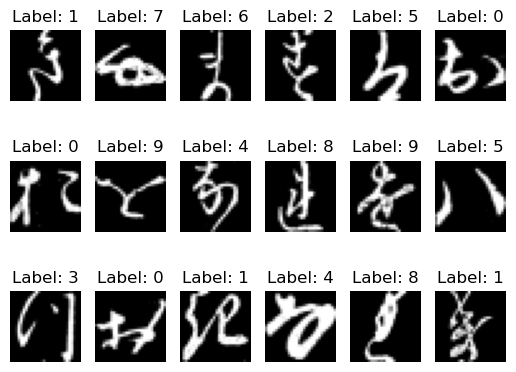

In [7]:
# Visualization of test dataset, see the augmentation
batch_idx, (data, target) = next(enumerate(test_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
  plt.subplot(3, 6, i+1)
  plt.imshow(data[i][0], cmap='gray')
  plt.title('Label: {}'.format(target[i]))
  plt.axis(False)

## Load the model

In [8]:
# Traditional CNN
class Cnn_mnist_v2(nn.Module):
    '''
    Convolution neural net work with 2 convolution layers and 2 fully connected layers.
    '''

    def __init__(self):
        super(Cnn_mnist_v2, self).__init__()
        # Convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.mp2 = nn.MaxPool2d(4)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.conv3 = nn.Conv2d(128, 200, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(200)
        self.conv3_drop = nn.Dropout2d(0.3)

        # Fully connect layer
        self.fc1 = nn.Linear(1800, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1_drop(self.bn1(self.conv1(x)))))
        x = F.relu(self.mp2(self.conv2_drop(self.bn2(self.conv2(x)))))
        x = F.relu(self.conv3_drop(self.bn3(self.conv3(x))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
# Inception CNN
class Inception(nn.Module):
    '''
    Inception helper for building inception layer.
    Output channels: 88
    '''
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

    
# Version 2
class Inception_mnist_v2(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.incept2 = Inception(in_channels=128)
        self.bn4 = nn.BatchNorm2d(88)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(4312, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        x = self.conv_drop(self.bn4(self.incept2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
# Version 3
class Inception_mnist_v3(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist_v3, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.incept2 = Inception(in_channels=128)
        self.bn4 = nn.BatchNorm2d(88)
        self.conv3 = nn.Conv2d(88, 200, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(200)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(9800, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        x = self.conv_drop(self.bn4(self.incept2(x)))
        x = F.relu(self.bn5(self.conv_drop(self.conv3(x))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
# Load the best parameters of model in training
cnn_model = Cnn_mnist_v2()
cnn_model.load_state_dict(torch.load('./model/Classic_cnn_v2.pth'))

incept_model_v2 = Inception_mnist_v2()
incept_model_v2.load_state_dict(torch.load('./model/Inception_cnn_v2.pth'))

incept_model_v3 = Inception_mnist_v3()
incept_model_v3.load_state_dict(torch.load('./model/Inception_cnn_v3.pth'))

<All keys matched successfully>

## Evaluate the model

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluation function
def evaluate_model(model, test_loader):
    
    model.eval()
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    cm_test = confusion_matrix(targets, predicted)

    print('Performance: ')
    print(classification_report(targets, predicted))
    print('Confusion matrix:')
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))


### Performance of classic CNN

Performance: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.98      0.97      0.98      1000
           2       0.95      0.96      0.96      1000
           3       0.97      0.99      0.98      1000
           4       0.98      0.96      0.97      1000
           5       0.99      0.97      0.98      1000
           6       0.96      0.99      0.98      1000
           7       0.99      0.99      0.99      1000
           8       0.99      0.98      0.98      1000
           9       0.99      0.98      0.99      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:


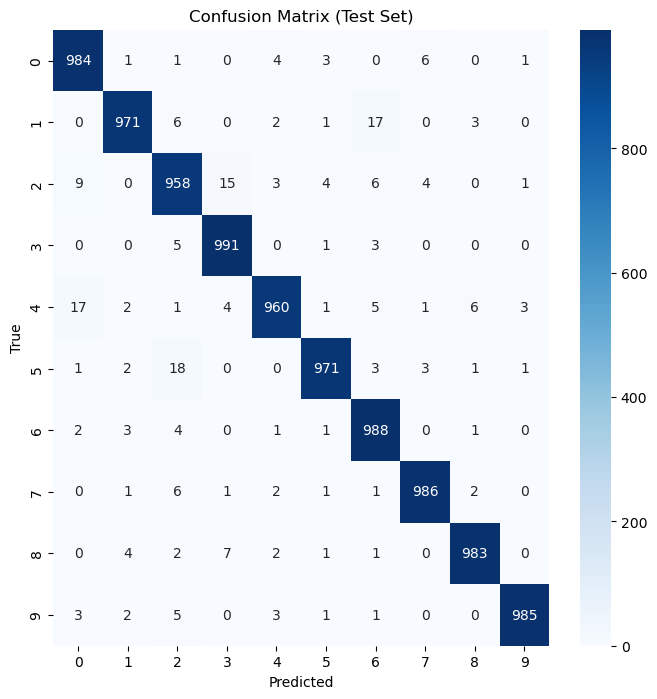


ACCURACY: 0.9777


In [15]:
# In test dataset
evaluate_model(model=cnn_model, test_loader=test_loader)

### Performance of Inception CNN

Performance: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.99      0.98      0.99      1000
           2       0.98      0.97      0.97      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.96      0.97      1000
           5       0.98      0.99      0.98      1000
           6       0.97      0.99      0.98      1000
           7       1.00      0.99      0.99      1000
           8       0.98      1.00      0.99      1000
           9       0.99      0.99      0.99      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:


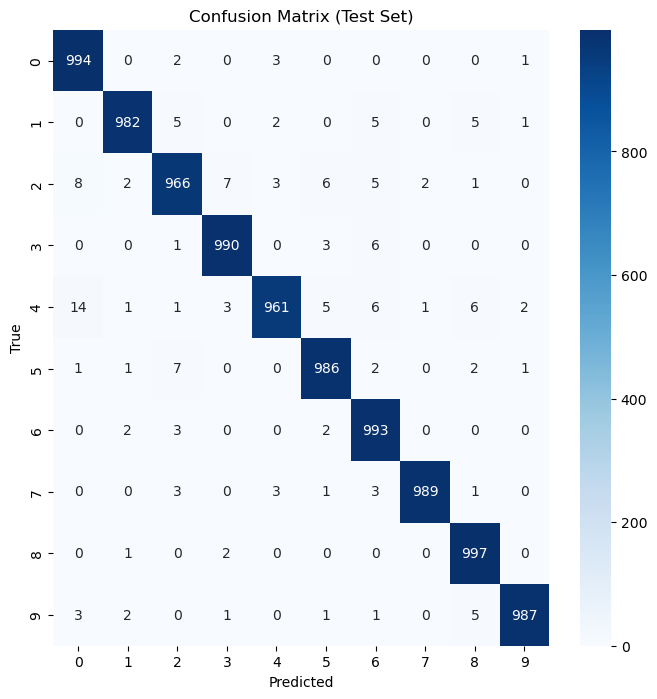


ACCURACY: 0.9845


In [17]:
# In version 2
evaluate_model(model=incept_model_v2, test_loader=test_loader)

Performance: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.98      0.98      1000
           2       0.98      0.97      0.98      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.97      0.98      1000
           5       0.99      0.98      0.99      1000
           6       0.97      0.99      0.98      1000
           7       0.99      0.99      0.99      1000
           8       0.98      0.99      0.99      1000
           9       1.00      0.99      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion matrix:


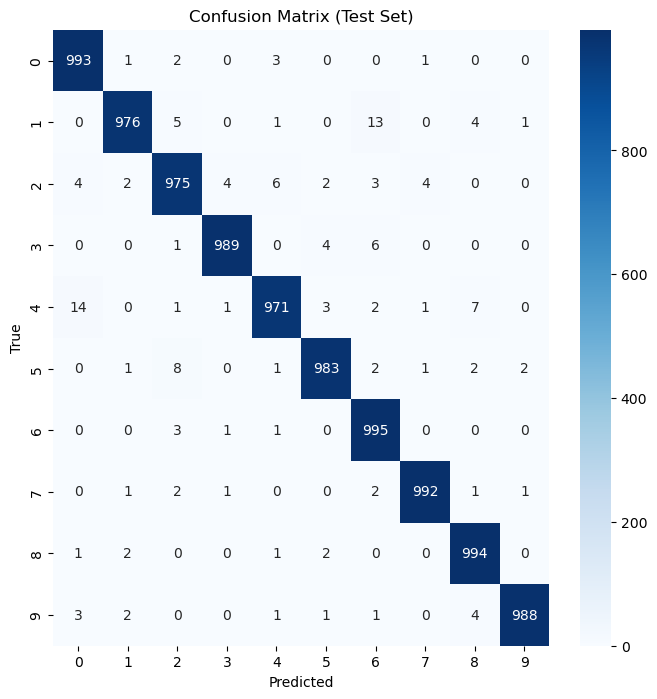


ACCURACY: 0.9856


In [18]:
# In version 3
evaluate_model(model=incept_model_v3, test_loader=test_loader)

### Ensembled CNN

In [24]:
models = [cnn_model, incept_model_v2, incept_model_v3]

def evaluate_ensembled(models, loader):
    for model in models:
        model.eval()
    
    inputs, targets = next(iter(test_loader))
    outputs = 1*models[0](inputs)/6 + 2*models[1](inputs)/6 + 3*models[2](inputs)/6
    _, predicted = torch.max(outputs, 1)
    cm_test = confusion_matrix(targets, predicted)
    
    print('Performance: ')
    print(classification_report(targets, predicted))
    print('Confusion matrix:')
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))

Performance: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.98      0.98      1000
           2       0.98      0.97      0.98      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.97      0.98      1000
           5       0.98      0.99      0.99      1000
           6       0.97      0.99      0.98      1000
           7       0.99      0.99      0.99      1000
           8       0.99      0.99      0.99      1000
           9       1.00      0.99      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion matrix:


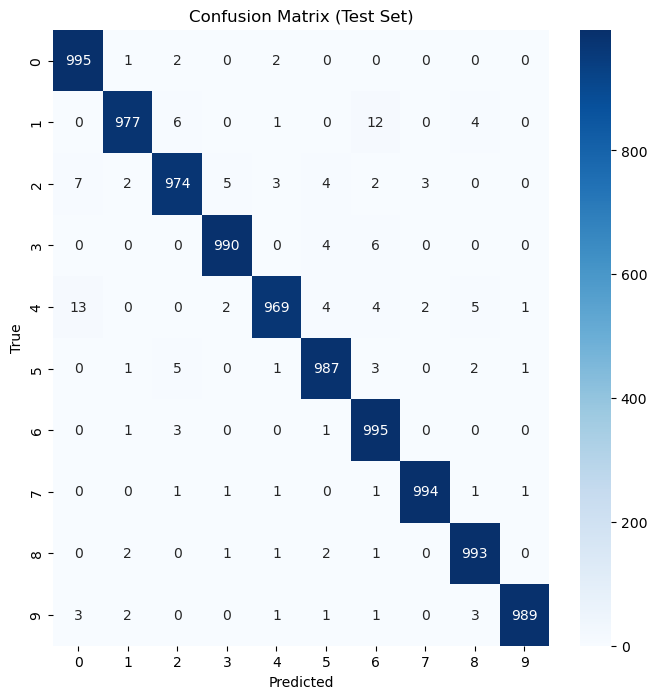


ACCURACY: 0.9863


In [25]:
evaluate_ensembled(models, test_loader)